## Project
Predict the risk of hospital readmission for patients who have been discharged from the hospital within the previous 30 days given the information in the attached dataset (taken from US Medicare patients)..

In [1]:
#import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns

In [53]:
# load the csv file
df = pd.read_csv('HospitalAdmissionPrediction.csv')
df.head()

,ID.Codes,Readmission.Status,Gender,Race,ER,DRG.class,LOS,Age,HCC.Riskscore,DRG.Complication
0,0005EC02F1DC3A15,0,M,White,0,MED,3,71,1.631,MedicalMCC.CC
1,0005EC02F1DC3A15,0,M,White,0,SURG,2,71,1.631,Other
2,0006C4369B0D7B5F,0,M,White,0,MED,2,68,0.585,MedicalNoC
3,000960C9E1C43BE4,0,F,White,0,SURG,12,79,1.660,SurgNoC
4,00098CF15837D918,0,M,White,0,SURG,4,91,1.768,SurgNoC


## EDA: Exploratory Data Analysis
Let's understand the dataset more

In [54]:
#check for any missing value
df.isnull().sum()

ID.Codes              0
Readmission.Status    0
Gender                0
Race                  0
ER                    0
DRG.class             0
LOS                   0
Age                   0
HCC.Riskscore         0
DRG.Complication      0
dtype: int64

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66782 entries, 0 to 66781
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID.Codes            66782 non-null  object 
 1   Readmission.Status  66782 non-null  int64  
 2   Gender              66782 non-null  object 
 3   Race                66782 non-null  object 
 4   ER                  66782 non-null  int64  
 5   DRG.class           66782 non-null  object 
 6   LOS                 66782 non-null  int64  
 7   Age                 66782 non-null  int64  
 8   HCC.Riskscore       66782 non-null  float64
 9   DRG.Complication    66782 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 5.1+ MB


In [56]:
df.describe()

,Readmission.Status,ER,LOS,Age,HCC.Riskscore
count,66782.000000,66782.000000,66782.000000,66782.000000,66782.000000
mean,0.125917,0.508281,6.693420,73.636309,2.345236
std,0.331758,0.817415,5.698282,13.337235,1.671520
min,0.000000,0.000000,1.000000,24.000000,0.079000
25%,0.000000,0.000000,3.000000,67.000000,1.107000
50%,0.000000,0.000000,5.000000,75.000000,1.865500
75%,0.000000,1.000000,8.000000,83.000000,3.173000
max,1.000000,9.000000,36.000000,101.000000,12.307000


In [57]:
#Now lets check the number of patients readmitted  within 30 days and those not admitted within 30 day: since 1 indicates readmitted and 0 indicates not admitted
df.groupby('Readmission.Status').size()

Readmission.Status
0    58373
1     8409
dtype: int64

In [58]:
#lets aslo check for all the data distribution, the number of patients readmitted  within 30 days and those not admitted within 30 day: since 1 indicates readmitted and 0 indicates not admitted
df.groupby('Readmission.Status').count()

,ID.Codes,Gender,Race,ER,DRG.class,LOS,Age,HCC.Riskscore,DRG.Complication
Readmission.Status,,,,,,,,,
0,58373,58373,58373,58373,58373,58373,58373,58373,58373
1,8409,8409,8409,8409,8409,8409,8409,8409,8409


Some important columns to check through

In [59]:
#some important columns, we need to check
df.groupby('DRG.Complication').size()

DRG.Complication
MedicalMCC.CC    18110
MedicalNoC       12310
Other             9367
SurgMCC.CC       15446
SurgNoC          11549
dtype: int64

In [60]:
df.groupby('DRG.class').size()

DRG.class
MED        35771
SURG       30447
UNGROUP      564
dtype: int64

In [61]:
df.groupby('Race').size()

Race
Black        7099
Hispanic     1286
Other        2273
White       56124
dtype: int64

Let's define a function to calculate the prevalence of population that is readmitted within 30 days and thoes that are not

In [62]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [63]:
print('Prevalence:%.3f'%calc_prevalence(df['Readmission.Status'].values))

Prevalence:0.126


In [64]:
# Lets take a look at unique values for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

ID.Codes: 37800 unique values
Readmission.Status
[0 1]
Gender
['M' 'F']
Race
['White' 'Other' 'Hispanic' 'Black']
ER
[0 1 2 3 4 6 5 9 7]
DRG.class
['MED' 'SURG' 'UNGROUP']
LOS: 36 unique values
Age: 78 unique values
HCC.Riskscore: 5595 unique values
DRG.Complication
['MedicalMCC.CC' 'Other' 'MedicalNoC' 'SurgNoC' 'SurgMCC.CC']


We can observe that the data is a mix of categorical and numerical datatype

## Feature Engineering
Here, We will create features for our predictive model. For each section, we will add new variables to the dataframe and then keep track of which columns of the dataframe we want to use as part of the predictive model features. We will break down this section into numerical featuresand categorical features 

## Numerical Features
We will create numerical varaibles

In [65]:
# You will notice that the column ID.Codes has been ignored here because it is not a determinant for our prediction but we can add it
Cols_num = ['HCC.Riskscore','LOS','Age','ER']  


## Categorical Features
The next step is to create are categorical variables. Categorical variables are non-numeric data such as race and gender. To turn these non-numerical data into variables, the simplest thing is to use a technique called one-hot encoding.

The first set of categorical data we will deal with are these columns:

In [66]:
Cols_cat = ['DRG.Complication','DRG.class', 'Gender','Race']

To convert our categorical features to numbers, we will use a technique called one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_white','race_hispanic', etc). If the patient's race is white, the patient gets a 1 under 'race_white' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the get_dummies function.
And since the get_dummies function does not work on numerical data.We can convert the numerical data into strings and then it will work properly.
The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly

Also note that we can add the column ID.codes here and convert it to string then use one hot encoding to the convert it to the required format but this would consume alot of our memomry.And also the column is doesnt have much of relevance to the end result. In this case i will just ignore that for now anc concentrate on the cols_cat

In [67]:
# This makes all our categorical Features ready
df_cat = df_cat = pd.get_dummies(df[Cols_cat])
df_cat

,DRG.Complication_MedicalMCC.CC,DRG.Complication_MedicalNoC,DRG.Complication_Other,DRG.Complication_SurgMCC.CC,DRG.Complication_SurgNoC,DRG.class_MED,DRG.class_SURG,DRG.class_UNGROUP,Gender_F,Gender_M,Race_Black,Race_Hispanic,Race_Other,Race_White
0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,1,0,0,1,0,0,0,1
2,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,1,0,1,0,0,0,0,1
4,0,0,0,0,1,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66777,0,0,1,0,0,0,0,1,0,1,0,0,0,1
66778,0,0,0,0,1,0,1,0,1,0,0,0,0,1
66779,0,1,0,0,0,1,0,0,1,0,0,0,0,1
66780,0,0,1,0,0,0,1,0,1,0,0,0,0,1


In [68]:
#adding the one hot encoding table to innitial data
df = pd.concat([df,df_cat], axis = 1)
cols_all_cat = list(df_cat.columns) # Saving the columns name

## Feature Engineering Summaries

In [69]:
print('Total number of features:', len(Cols_num + cols_all_cat))
print('Numerical Features:',len(Cols_num))
print('Categorical Features:',len(cols_all_cat))

Total number of features: 18
Numerical Features: 4
Categorical Features: 14


In [70]:
#lets check for any missing values
df[Cols_num + cols_all_cat ].isnull().sum().sort_values(ascending = False).head().sample(frac = 0.5)

Race_Black       0
HCC.Riskscore    0
dtype: int64

In [71]:
# Now let's select the columns we want to use for prediction
col_use = Cols_num + cols_all_cat 
df_data = df[col_use + ["Readmission.Status"]]

## Building Training | Validation |Test Samples
In this project, We will split the data into 70% train and 30% test ( 15% validation and 15% test).

The first thing I would  like to do is to shuffle the samples using sample in case there was some order (e.g. all positive samples on top). Here n is the number. random_state is just specified so the entire class gets the same shuffling. You wouldn't need random_state in your own projects.

In [72]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

In [73]:
# Let's Save 30% of the data as validation and test data using frac
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [74]:
#And now split into test and validation using 50% fraction.
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

Note that I just drop the rows from df_test to get the rows that were not part of the sample.
We can use this same idea to get the training data

In [75]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

let's check what percent of our groups are hospitalized within 30 days. This is known as prevalence. Ideally, all three groups would have similar prevalance.

In [76]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test['Readmission.Status'].values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid['Readmission.Status'].values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all['Readmission.Status'].values)))

Test prevalence(n = 10018):0.127
Valid prevalence(n = 10017):0.128
Train all prevalence(n = 46747):0.125


The prevelance is about the same in each group : 12

In [77]:
#Let's verify that we used all the data.
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 66782)


At this point, we might want to consider dropping the training data into a predictive model and see the outcome. However, if we do this, it is possible that we will get back a model that is 89% accurate. This is Great! However, we never catch any of the readmissions (recall= 0%). How can this happen?

What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative.

Typically, it will be better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized:

- sub-sample the more dominant class: use a random subset of the negatives
- over-sample the imbalanced class: use the same positive samples multiple times
- create synthetic positive data

Usually, we would want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement.

In [78]:
# split the training data into positive and negative
rows_pos = df_train_all['Readmission.Status'] == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train['Readmission.Status'].values)))

Train balanced prevalence(n = 11716):0.500


In [79]:
# it is important that we save our data
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [80]:
#lets create input matrix X and output vector y for our model
X_train = df_train[col_use].values
X_train_all = df_train_all[col_use].values
X_valid = df_valid[col_use].values

y_train = df_train['Readmission.Status'].values
y_valid = df_valid['Readmission.Status'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (46747, 18)
Training shapes: (11716, 18) (11716,)
Validation shapes: (10017, 18) (10017,)


In [82]:
#lets install sklearn
!pip install sklearn


  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=5dd3830aec1ddb79d8fa06f299b6fd9f0a9e164dd085412b2f5e54909861c497
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


Here we will use scikit learn's Standard Scaler which to remove the mean and scales to unit variance. I will create a scaler using all the training data.

In [114]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [84]:
# since we would need  this scaler lets's save it using pickle
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [85]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [86]:
#now we can transform our Matrix
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

## Model Selection

In this section, we would train a few machine learning models and use a few techniques for optimizing them. We will then select the best model based on performance on the validation set.

We will utilize the below functions to evaluate the performance of the model

In [92]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

In [93]:
#Since we have balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive.
thresh = 0.5

In [ ]:
# Lets take a sample of 2% from the Cols_cat_num to avoid running out of memory
Cols_cat_num = ['ID.Codes']
df[Cols_cat_num] = df[Cols_cat_num].astype('str').sample(frac =0.2)

## Model Selection: 
We will build and compare the performance of 5 machine learning models using default hyperparameters.

## Logistic Regression

In [122]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [123]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.738
accuracy:0.664
recall:0.594
precision:0.691
specificity:0.734
prevalence:0.500
 
Validation:
AUC:0.737
accuracy:0.719
recall:0.609
precision:0.252
specificity:0.735
prevalence:0.128
 


## K- Nearest Neighbors (KNN)

In [124]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [125]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.725
accuracy:0.663
recall:0.616
precision:0.680
specificity:0.688
prevalence:0.500
 
Validation:
AUC:0.710
accuracy:0.688
recall:0.607
precision:0.229
specificity:0.680
prevalence:0.128
 


## Decision Tree

In [126]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [127]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.805
accuracy:0.722
recall:0.816
precision:0.687
specificity:0.621
prevalence:0.500
 
Validation:
AUC:0.681
accuracy:0.576
recall:0.741
precision:0.195
specificity:0.546
prevalence:0.128
 


## Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [129]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.760
accuracy:0.683
recall:0.794
precision:0.649
specificity:0.571
prevalence:0.500
 
Validation:
AUC:0.733
accuracy:0.592
recall:0.780
precision:0.208
specificity:0.565
prevalence:0.128
 


## Gradient Boosting Classifier

In [130]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [131]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.825
accuracy:0.739
recall:0.771
precision:0.725
specificity:0.707
prevalence:0.500
 
Validation:
AUC:0.693
accuracy:0.615
recall:0.688
precision:0.203
specificity:0.604
prevalence:0.128
 


## Analyze results baseline models

Let's make a dataframe with these results and plot the outcomes using a package called seaborn. In this project, we will utilize the Area under the ROC curve (AUC) to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between the true positive and false positive and does not require selecting a threshold. 

In [141]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*5,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_train_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_train_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

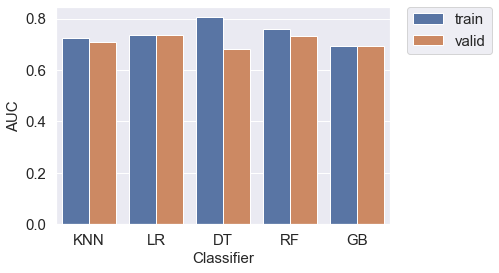

In [143]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

Now let's improve the model performances

## Model Selection: Learning Curve
We will make use of the learning curve code from scikit-learn's website with a small change of plotting the AUC instead of accuracy. http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html. 

In [145]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

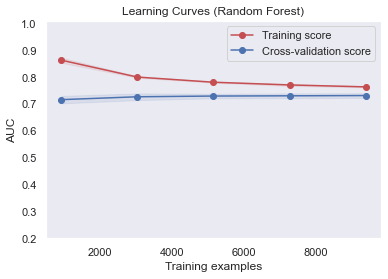

In [146]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the case of random forest, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting.

Depending on your learning curve, there are a few strategies you can employ to improve your models

High Bias:
Add new features
* Increase model complexity
* Reduce regularization
* Change model architecture 

High Variance:
* Add more samples
* Add regularization
* Reduce number of features
* Decrease model complexity
* Add better features
* Change model architecture

### Model Selection: Feature Importance

One path for improving your models to understand what features are important to your models. This can usually only be investigated for simpler models such as Logistic Regression or Random Forests. This analysis can help in a few areas:
- inspire new feature ideas -- helps with both high bias and high variance
- obtain a list of the top features to be used for feature reduction --> helps with high variance
- point out errors in your pipeline -- helps with robustness of model
Let's get the feature importance for a few models and then we can discuss what we see. 

### Feature Importance: Logistic regression

Note that we have normalized the data so the coefficients are comparable between variables. We can extract the coefficients using coef_ and store in a new dataframe (sorted by importance) 

In [150]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col_use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [151]:
feature_importances.head()

,importance
HCC.Riskscore,0.804803
LOS,0.058094
DRG.Complication_Other,0.044909
DRG.class_MED,0.026163
DRG.Complication_SurgMCC.CC,0.022553


For logistic regression, the variables with highest positive coefficients are predictive of re-hospitalization and the variables with highest negative coefficients are predictive of not being re-hospitalized. We can plot the top 10 for each direction below. 

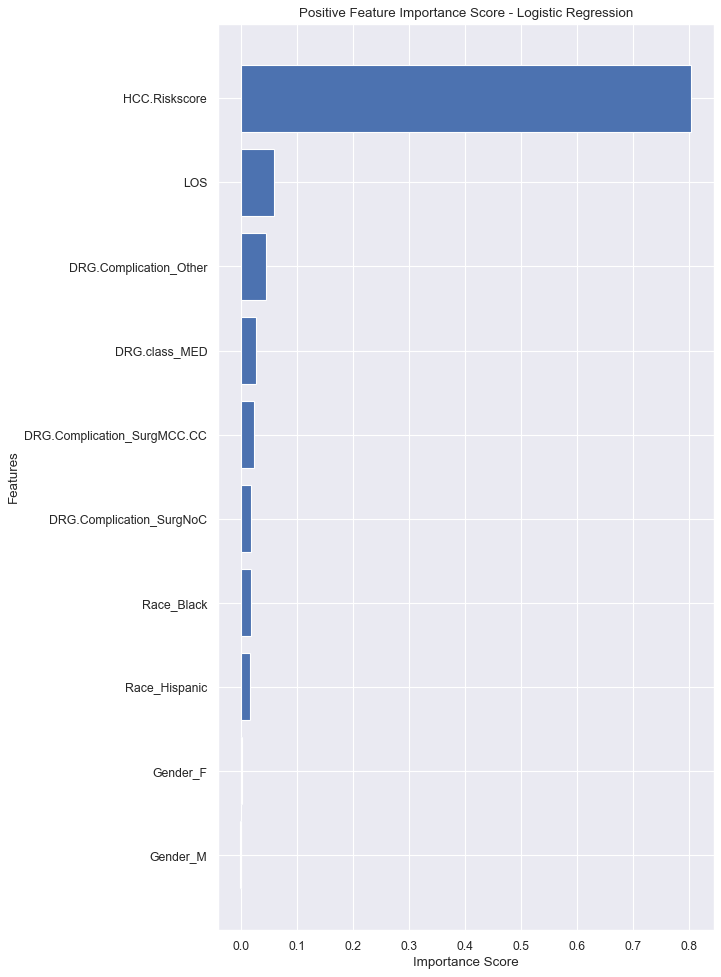

In [158]:
num = 10
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

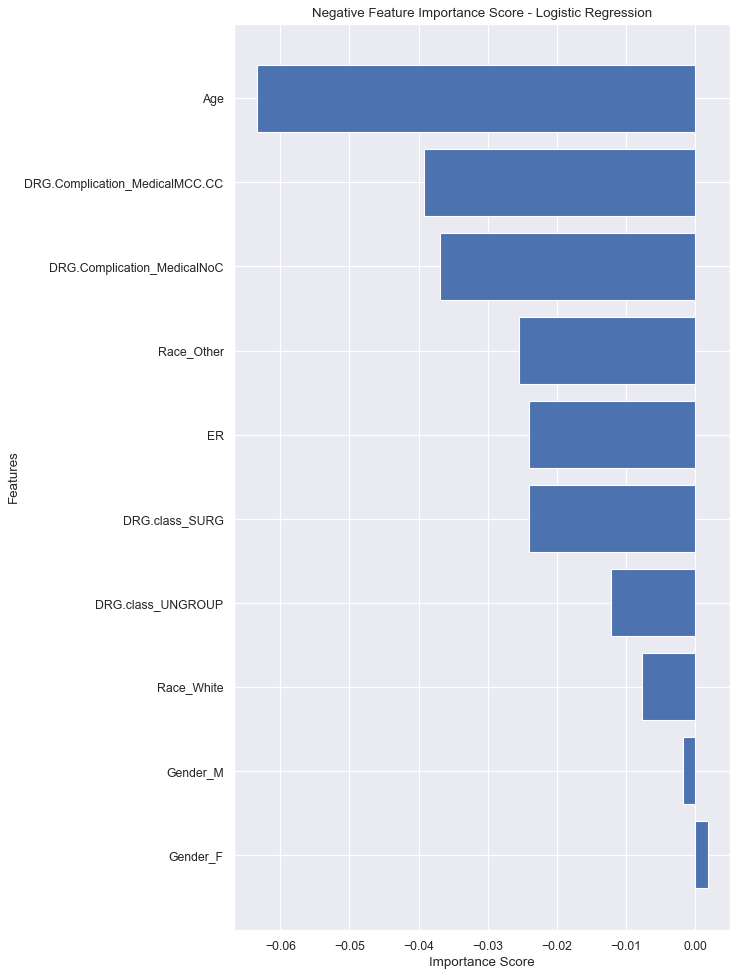

In [159]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

### Feature Importance: random forest

We can also investigate feature importance for random forest models. In this case, the feature importance shows how often a particular feature was used to split the data. However, we don't know if a particular feature is correlated with the positive class or negative class, but rather it is just importance for making a decision. 

In [161]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col_use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [162]:
feature_importances.head()

,importance
HCC.Riskscore,0.813845
LOS,0.075208
Age,0.047065
ER,0.014661
DRG.Complication_Other,0.007871


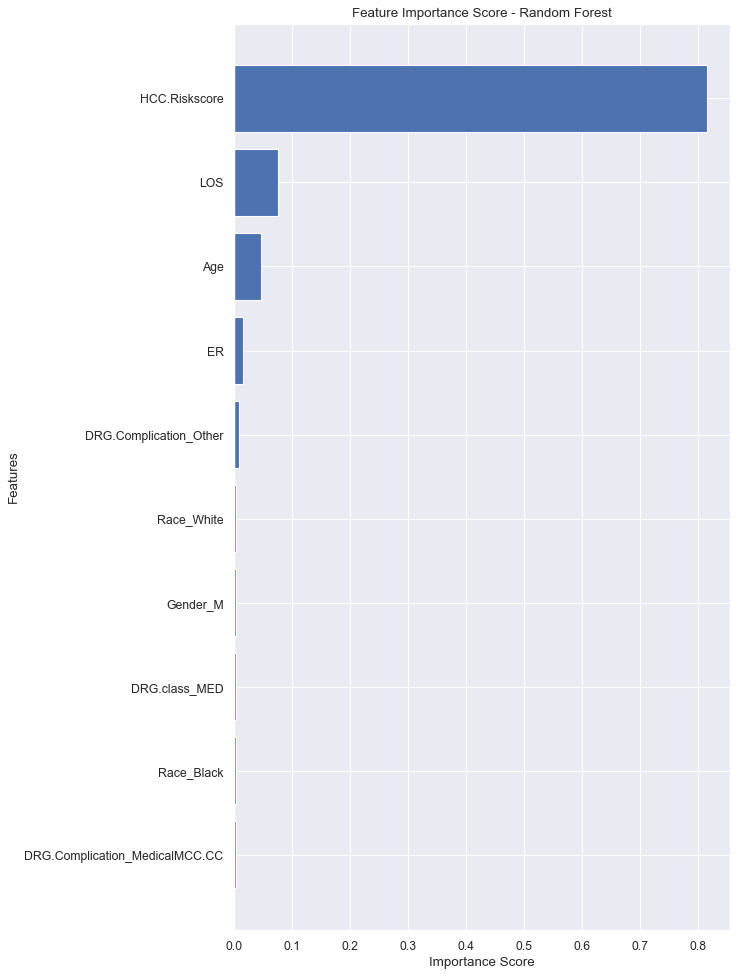

In [163]:
num = 10
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

From the above visualisation, most of the important variables for random forest are continuous variables. This makes sense since you can split continuous variables more times than categorical variables

### Model Selection: Hyperparameter tuning
Hyperparameter tuning are essentially the design decisions that you made when you set up the machine learning mode. These hyperparameters can be optimized to improve the model performance.

Here, we will only optimize the hyper parameters for random forest and gradient boosting classifier. We will not optimize KNN since it took a while to train. We will not optimize Logistic regression and decision trees since they tend to overfit and perform worse that random forests and gradient boosting classifiers.
We are going to use the grid search technique fot the hyperparameter tunning

In [164]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Let's create a grid search as below

In [166]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In order to use the RandomizedSearchCV function, we need something to score or evaluate a set of hyperparameters. Here we will use the auc

In [168]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [169]:
# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [170]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
265.25568079948425


Lets take a look at the best parameters

In [173]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 4,
 'max_features': 'sqrt',
 'max_depth': 6,
 'criterion': 'entropy'}

In [174]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.760
Validation AUC:0.733
Optimized Random Forest
Training AUC:0.760
Validation AUC:0.733


Optimize gradient boosting classifier

In [175]:
# number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

167.19542288780212


In [176]:
gbc_random.best_params_

{'n_estimators': 400, 'max_depth': 1, 'learning_rate': 0.01}

In [177]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.825
Validation AUC:0.693
Optimized gbc
Training AUC:0.739
Validation AUC:0.735


### Hyperparameter Tuning Result

In [180]:
df_results = pd.DataFrame({'classifier':['RF','RF','GB','GB'],
                           'data_set':['base','optimized']*2,
                          'auc':[rf_valid_auc_base,rf_valid_auc,
                                 gbc_valid_auc_base,gbc_valid_auc,],
                          })

In [181]:
df_results

,classifier,data_set,auc
0,RF,base,0.732926
1,RF,optimized,0.732555
2,GB,base,0.692682
3,GB,optimized,0.735448


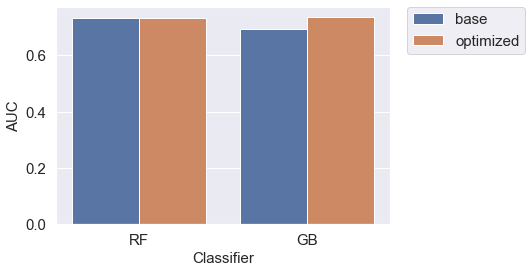

In [182]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

We can see that the Hyperparameter improved the result but not so much

Model Selection: Best Classifier

Here we will chose the gradient boosting classifier since it has the best AUC on the validation set. You won't want to train your best classifier every time you want to run new predictions. Therefore, we need to save the classifier. We will use the package pickle.

In [184]:

pickle.dump(gbc_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

### Model Evaluation

Now that we have selected our best model. Let's evaluate the performance of the test set.

In [188]:
X_test = df_test[col_use].values
y_test = df_test['Readmission.Status'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [189]:
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [190]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [193]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.739
accuracy:0.675
recall:0.757
precision:0.651
specificity:0.594
prevalence:0.500
 
Validation:
AUC:0.735
accuracy:0.619
recall:0.752
precision:0.216
specificity:0.599
prevalence:0.128
 
Test:
AUC:0.746
accuracy:0.626
recall:0.772
precision:0.221
specificity:0.605
prevalence:0.127
 


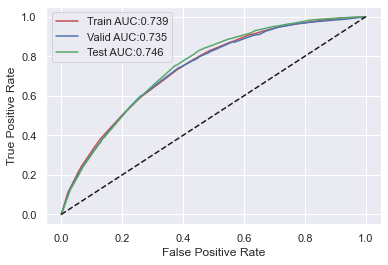

In [192]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Conclusion

We created a binary classifier to predict the probability that a patient would be readmitted to the hospital within 30 days. On held out test data, our best model had an AUC of of 0.74. Using this model, we are able to catch 77% of the readmissions from our model that performs approximately 1.5 times better than randomly selecting patients.